In [60]:
#importing libraries
import random
from IPython.display import clear_output, display
import time
import chess
import numpy as np
import itertools

In [61]:
#Defining the Node
class Node:
    def __init__(self, move, value, parent=None):
        self.move = move
        self.value = value
        self.parent = parent
        self.children = list()
    

In [62]:
piece_value_map = {
    chess.PAWN: 100,
    chess.KNIGHT: 300,
    chess.BISHOP: 300,
    chess.ROOK: 500,
    chess.QUEEN: 900,
    chess.KING: 10000
}

In [63]:
def cal_material(observation, turn):
    total = 0
    
    #number of pawns
    total += len(observation.pieces(chess.PAWN, turn)) * piece_value_map[chess.PAWN]
    #number of white knights
    total += len(observation.pieces(chess.KNIGHT, turn)) * piece_value_map[chess.KNIGHT]
    #number of bishops
    total += len(observation.pieces(chess.BISHOP, turn)) * piece_value_map[chess.BISHOP]
    #number of rooks 
    total += len(observation.pieces(chess.ROOK, turn)) * piece_value_map[chess.ROOK]
    #number of queens
    total += len(observation.pieces(chess.QUEEN, turn)) * piece_value_map[chess.QUEEN]
    
    return total


#function to evaluate the board
def evaluate_board(observation):
    #get sum of both sides points
    white_eval = cal_material(observation, chess.WHITE)
    black_eval = cal_material(observation, chess.BLACK)
    
    #Negative board value means black is leading, positive means white
    evaluation = white_eval - black_eval
    
    #if it is black's turn flip the sign to reflect black's evaluation
    perspective = 1
    if not observation.turn: 
        perspective *= -1 
    
    return evaluation*perspective

    #end result will be:
        #if it is white's turn, positive is better negative is better
        #if it is black's turn, positive is better and negative is better
    
#Search Function
def search(observation, depth, alpha, beta):
    
    if depth == 0:
        return search_all_captures(observation, alpha, beta)
    if observation.is_checkmate():
        return -1e9
    if observation.is_stalemate():
        return 0
    
    moves = list(observation.legal_moves)
    moves.sort(key=lambda x: eval_move(observation, x), reverse=True)
    
    for move in moves:
        observation.push(move)
        evaluation = -search(observation, depth-1, -beta, -alpha)
        observation.pop()
        if evaluation >= beta:
            return beta
        alpha = max(alpha, evaluation)
        
    return alpha

def eval_move(board, move):
    move_score = 0
    move_piece = board.piece_type_at(move.from_square)
    capture_piece = board.piece_type_at(move.to_square)
    
    if capture_piece:
        move_score = 10 * piece_value_map[capture_piece] - piece_value_map[move_piece]
    
    if move.promotion:
        move_score += piece_value_map[move.promotion]
    
    enemy_pawn_squares = board.pieces(chess.PAWN, not board.turn)
    attacked_by_pawns = list(itertools.chain.from_iterable(map(board.attacks, enemy_pawn_squares)))
    if move.to_square in attacked_by_pawns:
        move_score -= piece_value_map[move_piece]
    
    return move_score
    
def search_all_captures(observation, alpha, beta):
    evaluation = evaluate_board(observation)

    if evaluation >= beta:
        return beta
    alpha = max(alpha, evaluation)

    capture_moves = [x for x in observation.legal_moves if observation.is_capture(x)]

    for move in capture_moves: 

        observation.push(move)
        evaluation = -search_all_captures(observation, -beta, -alpha)
        observation.pop()

        if evaluation >= beta:
            return beta
        alpha = max(alpha, evaluation)

    return alpha

In [64]:
class AlphaBetaAgent:
    
    def alpha_beta_search(self, board, depth):
            evaluations = list()
            for move in board.legal_moves:
                board.push(move)
                evaluations.append((move, -search(board, depth-1, -1e9, 1e9)))
                board.pop()
            return max(evaluations, key=lambda x: x[1])[0]

In [65]:
import chess.svg
import cProfile
import pstats

SCENARIO_1 = '4k3/4P3/3PK3/8/8/8/8/8 w - - 0 1'
SCENARIO_2 = '8/3k4/8/8/8/3K4/3R4/3R4 w - - 0 1'
SCENARIO_3 = 'r1bqk1nr/ppp1bppp/3p4/n3p3/2B1P3/2NP1N2/PPP2PPP/R1BQK2R w KQkq - 1 6'
SCENARIO_4 = 'r3k2r/p4pp1/7p/1b1pq2B/2pnp3/2Q2P2/P2N2Pb/2R2R1K b kq - 3 29'

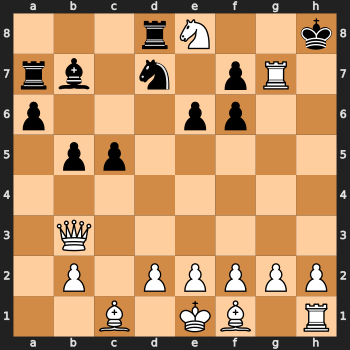

'True'

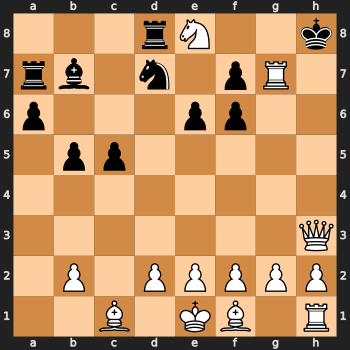

Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)

In [67]:
agent = AlphaBetaAgent()
board = chess.Board()
time_to_move_1 = list()
time_to_move_2 = list()

with cProfile.Profile() as pr:
    while not board.is_game_over():
        clear_output(wait=True)
        display(chess.svg.board(board, size=350))
        display(f'{board.turn}')
        if board.turn:
            start = time.perf_counter()
            action = agent.alpha_beta_search(board, 4)
            time_to_move_1.append(time.perf_counter() - start)
        else:
            start = time.perf_counter()
            action = random.choice(list(board.legal_moves))
            time_to_move_2.append(time.perf_counter() - start)
        board.push(action)

display(chess.svg.board(board, size=350))
board.outcome()

In [68]:
stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.TIME)
stats.print_stats()

         615561007 function calls (613713400 primitive calls) in 249.243 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 22429712   20.262    0.000   46.470    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:1650(generate_pseudo_legal_moves)
 50698543   14.435    0.000   16.578    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:269(scan_forward)
  1893243   14.015    0.000   50.838    0.000 <ipython-input-63-8246eb4b869a>:61(eval_move)
 46117127   12.024    0.000   14.172    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:278(scan_reversed)
 21810643   11.346    0.000   24.645    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:3450(_is_safe)
 21844699   11.014    0.000   88.403    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:3488(generate_legal_moves)
 18900348   10.988    0.000   13.783    0.000 C:\Users\engli\anaconda3\lib\s

In [13]:
sum(time_to_move_1)

45.14645739999999

In [14]:
sum(time_to_move_2)

40.76484609999996

In [51]:
board = chess.Board(SCENARIO_3)
start = time.perf_counter()
evaluations = list(map(list, zip(board.legal_moves, [0 for x in board.legal_moves])))
for d in range(1, 6):
    for i, _ in enumerate(evaluations):
        board.push(evaluations[i][0])
        evaluations[i][1] = -search(board, d-1, -1e9, 1e9)
        board.pop()
    evaluations.sort(key=lambda x: x[1], reverse=True)
with_deepening = time.perf_counter() - start

In [52]:
with_deepening

158.93091570000024

In [59]:
start = time.perf_counter()
evaluations = list()
for move in board.legal_moves:
    board.push(move)
    evaluations.append((move, -search(board, 5-1, -1e9, 1e9)))
    board.pop()
without_deepening = time.perf_counter() - start    

KeyboardInterrupt: 

In [54]:
without_deepening

151.01680320000014

In [ ]:
display(chess.svg.board(board, size=350))

In [ ]:
board.turn

In [ ]:
without_deepening